# Analyzing fire payrolls in L.A.: 2011-2018

This notebook processess government payroll [data](https://publicpay.ca.gov/Reports/RawExport.aspx) compiled and released annually by the California state controller's office. The data include anonymized salary information for all employees at cities, counties, special districts and state government. 

---

### Load python tools

In [1]:
import altair as alt
import altair_latimes as lat
import pandas as pd
import geopandas as gpd
import cpi
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.0f}'.format
cpi.update()

### Import fire payroll data

In [2]:
# processed in 01-california-payroll-descriptives
agency_ot = pd.read_csv('output/agency_overtime.csv')
agency_ot_share = pd.read_csv('output/agency_overtime_share_ot.csv')
payroll_fire = pd.read_csv('/Users/mhustiles/data/data/controller/output/payroll_fire.csv')

---

### Filter dataframe to include only Los Angeles city and county fire

In [3]:
la = pd.DataFrame(payroll_fire[payroll_fire['employer'] == 'LOS ANGELES'])

In [4]:
la.employerfull = la.employerfull.str.replace('_', ' ')

In [5]:
la_agencies = la.groupby(['employerfull', 'year', 'type'])\
    .agg({'adjusted_overtime':'sum'}).reset_index()

In [6]:
la_agencies

,employerfull,year,type,adjusted_overtime
0,LOS ANGELES CITY,2011,CITY,"106,442,381"
1,LOS ANGELES CITY,2012,CITY,"122,766,643"
2,LOS ANGELES CITY,2013,CITY,"150,689,736"
3,LOS ANGELES CITY,2014,CITY,"170,170,047"
4,LOS ANGELES CITY,2015,CITY,"194,577,723"
5,LOS ANGELES CITY,2016,CITY,"193,805,688"
6,LOS ANGELES CITY,2017,CITY,"200,297,491"
7,LOS ANGELES CITY,2018,CITY,"194,037,539"
8,LOS ANGELES COUNTY,2011,COUNTY,"140,594,166"
9,LOS ANGELES COUNTY,2012,COUNTY,"145,007,457"


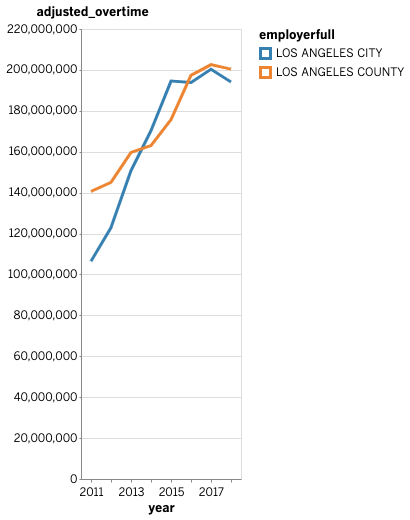

In [7]:
alt.Chart(la_agencies).mark_line().encode(
    x='year:O',
    y='adjusted_overtime',
    color='employerfull'
)

In [8]:
la_agencies.to_csv('output/la_agencies.csv')

---

### Create a dataframe combining and pivoting listing all the large places

In [9]:
la_pivot_ot = pd.DataFrame(pd.pivot_table(la_agencies, \
                values='adjusted_overtime', index=['employerfull', 'type'], columns=['year']).reset_index().fillna(0))

In [10]:
la_pivot_ot.columns = la_pivot_ot.columns.map(str)

### What did each fire department pay in overtime (just to firefighter titles) each year? 

In [11]:
la_pivot_ot['ot_pct_change'] = \
                ((la_pivot_ot['2018']-la_pivot_ot['2011'])/\
                 la_pivot_ot['2011'])*100

In [12]:
la_pivot_ot.head()

year,employerfull,type,2011,2012,2013,2014,2015,2016,2017,2018,ot_pct_change
0,LOS ANGELES CITY,CITY,"106,442,381","122,766,643","150,689,736","170,170,047","194,577,723","193,805,688","200,297,491","194,037,539",82
1,LOS ANGELES COUNTY,COUNTY,"140,594,166","145,007,457","159,648,826","163,014,544","175,704,520","197,369,374","202,569,406","200,371,155",43


In [13]:
#2011
'${:,.0f}'.format((la_pivot_ot.iloc[1,2] + la_pivot_ot.iloc[0,2]))

'$247,036,547'

In [14]:
#2018
'${:,.0f}'.format((la_pivot_ot.iloc[1,9] + la_pivot_ot.iloc[0,9]))

'$394,408,694'

In [15]:
'{:,.2f}%'.format(((la_pivot_ot.iloc[1,9] + la_pivot_ot.iloc[0,9])-(la_pivot_ot.iloc[1,2] + la_pivot_ot.iloc[0,2]))\
        / (la_pivot_ot.iloc[1,2] + la_pivot_ot.iloc[0,2])*100)

'59.66%'

In [16]:
la_pivot_ot.to_csv('output/la_city_county.csv')

---

### Charting firefighter wages and benefits in Los Angeles

In [17]:
la_all = la.groupby(['year', 'employerfull']).agg({'adjusted_overtime':'sum', \
                                            'adjusted_basewages':'sum', \
                                        'adjusted_wages':'sum', \
                                            'adjusted_benefits':'sum'\
                                            }).reset_index()

### Clean up the column names

In [18]:
la_all.rename(columns={'adjusted_overtime': 'Overtime',\
                    'adjusted_basewages': 'BaseWages',\
                   'adjusted_wages': 'Wages',\
                   'adjusted_benefits':'Benefits',\
                     'year': 'Year',
                      'employerfull': 'Place'}, inplace=True)

### Melt the dataframe for charting

In [19]:
la_melt = pd.melt(la_all,id_vars=['Year', 'Place'], value_vars=['Overtime','BaseWages'],\
        var_name='Compensation', value_name='Total')

### Chart the overtime amount in annual dollars

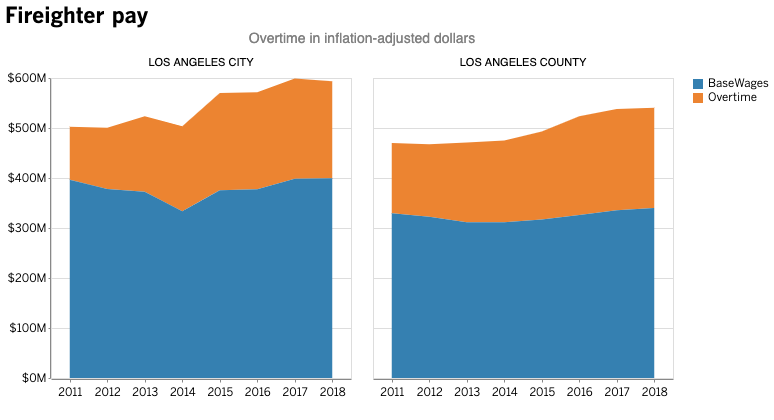

In [20]:
otdollars = alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", title=' ', axis=alt.Axis(tickCount=6, format='$,s')),
    color=alt.Color("Compensation:N", title=''),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet=alt.Facet('Place:N', title='Overtime in inflation-adjusted dollars')
).properties(width=300, height=300, columns=2, title='Fireighter pay')

otdollars.configure_header(
    titleColor='gray',
    titleFontSize=14,
    titleFontWeight = 'normal',
    titleOrient = 'top',
    titleAnchor='middle',
    titlePadding=10,
    labelFontSize=11
).configure_legend(
    orient='right'
)

In [21]:
la_melt.sort_values(by=['Place', 'Compensation', 'Year'], ascending=True)

,Year,Place,Compensation,Total
16,2011,LOS ANGELES CITY,BaseWages,"396,306,323"
18,2012,LOS ANGELES CITY,BaseWages,"377,794,902"
20,2013,LOS ANGELES CITY,BaseWages,"372,589,009"
22,2014,LOS ANGELES CITY,BaseWages,"333,382,422"
24,2015,LOS ANGELES CITY,BaseWages,"375,669,446"
26,2016,LOS ANGELES CITY,BaseWages,"377,712,120"
28,2017,LOS ANGELES CITY,BaseWages,"398,616,488"
30,2018,LOS ANGELES CITY,BaseWages,"399,477,016"
0,2011,LOS ANGELES CITY,Overtime,"106,442,381"
2,2012,LOS ANGELES CITY,Overtime,"122,766,643"


### Normalized version

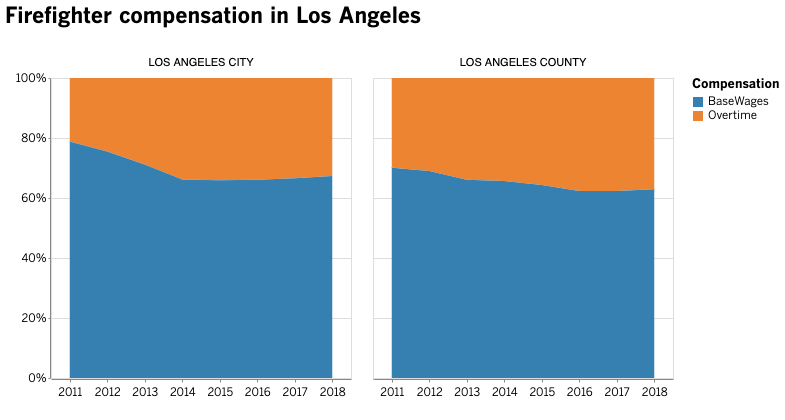

In [22]:
otshare = alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", stack="normalize", title=' ', axis=alt.Axis(tickCount=6, format='%')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet=alt.Facet('Place:N', title=' ')
).properties(width=300, height=300, columns=2, title='Firefighter compensation in Los Angeles')

otshare.configure_header(
    titleColor='gray',
    titleFontSize=14,
    titleFontWeight = 'normal',
    titleOrient = 'top',
    titleAnchor='middle',
    titlePadding=10,
    labelFontSize=11
).configure_legend(
    orient='right'
)

In [23]:
la_melt.sort_values(by=['Place', 'Compensation']).to_csv('output/la_melt.csv')

---

### How many firefighters received six-figure amounts of overtime in a year?

In [24]:
la_highest = la[la['overtime'] > 200000]

In [25]:
la_high = la[la['overtime'] > 100000]

In [26]:
print('$200k:',len(la_highest),'| $100k:',len(la_high)) 

$200k: 165 | $100k: 5022


### Group by agency type and year and count recipients of $100k overtime

In [34]:
la_high_years = la_high.groupby(['year','type']).agg('size').reset_index(name='count')
la_high_years.sort_values(by='type', ascending=False).head(25)

,year,type,count
1,2011,COUNTY,20
3,2012,COUNTY,58
5,2013,COUNTY,161
7,2014,COUNTY,220
9,2015,COUNTY,408
11,2016,COUNTY,577
13,2017,COUNTY,631
15,2018,COUNTY,611
0,2011,CITY,21
2,2012,CITY,49


### Group by agency type and year and count recipients of $200k overtime

In [33]:
la_highest_years = la_highest.groupby(['year','type']).agg('size').reset_index(name='count')
la_highest_years.sort_values(by='type', ascending=False).head(25)

,year,type,count
4,2016,COUNTY,19
6,2017,COUNTY,25
8,2018,COUNTY,20
0,2013,CITY,5
1,2014,CITY,6
2,2015,CITY,19
3,2016,CITY,22
5,2017,CITY,26
7,2018,CITY,23


### Group by agency type and year and count recipients of $200k overtime 

In [28]:
la_highest_years = la_highest.groupby(['year','type']).agg('size').reset_index(name='count')

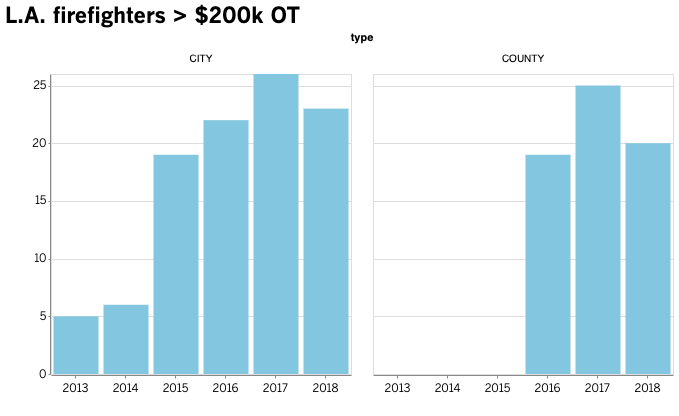

In [29]:
alt.Chart(la_highest_years).mark_bar().encode(
    x=alt.X("year:N", title=' '),
    y=alt.Y("mean(count):Q", title=' ', axis=alt.Axis(tickCount=6, format='')),
    facet='type:O'
).properties(width=300, height=300, columns=2, title='L.A. firefighters > $200k OT')

In [30]:
la_highest_years.sort_values(by=['type','year'], ascending=False).head(20)

,year,type,count
8,2018,COUNTY,20
6,2017,COUNTY,25
4,2016,COUNTY,19
7,2018,CITY,23
5,2017,CITY,26
3,2016,CITY,22
2,2015,CITY,19
1,2014,CITY,6
0,2013,CITY,5


In [31]:
la_high_positions = la_high.groupby('position').agg({'adjusted_overtime':'sum', \
    'adjusted_basewages':'sum', \
    'adjusted_wages':'sum', \
    'adjusted_benefits':'sum'\
}).reset_index()

### Payroll by title

In [32]:
la_high_positions.sort_values(by='adjusted_overtime', ascending=False)

,position,adjusted_overtime,adjusted_basewages,adjusted_wages,adjusted_benefits
5,FIRE CAPTAIN (56 HOUR),"171,225,657","176,960,584","348,186,241","77,528,270"
20,FIREFIGHTER III,"93,816,710","84,380,423","178,197,133","18,463,642"
6,FIRE CAPTAIN I,"84,006,030","83,818,995","167,825,025","16,675,768"
10,FIRE FIGHTER (56 HOUR),"77,656,073","71,935,684","149,591,757","32,927,554"
11,FIRE FIGHTER SPECIALIST (56 HOUR),"74,232,854","71,203,733","145,436,587","32,292,546"
7,FIRE CAPTAIN II,"37,298,594","38,764,605","76,063,199","7,839,441"
1,BATTALION CHIEF/56 HOURS/,"31,975,392","40,562,865","72,538,257","19,664,151"
2,ENGINEER OF FIRE DEPARTMENT,"29,327,375","27,134,117","56,461,492","5,456,447"
4,FIRE BATTALION CHIEF,"15,743,671","20,729,379","36,473,050","3,715,047"
16,FIRE INSPECTOR I,"14,522,499","13,690,186","28,212,685","3,365,769"


---

Data source: https://publicpay.ca.gov/Reports/RawExport.aspx